In [1]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import pandas as pd

def load_data_in_chunks(file_path, chunksize=10000):
    """Loads the dataset in chunks and returns a generator."""
    for chunk in pd.read_csv(file_path, chunksize=chunksize):
        yield chunk

# File path to your dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/NLP/NLP project/NLPDataset.csv'

# Load data in chunks
data_chunks = load_data_in_chunks(file_path)


In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download the 'stopwords' dataset if it hasn't been downloaded already
nltk.download('stopwords')
# Download the 'wordnet' dataset
nltk.download('wordnet')

# Initialize lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """Preprocesses the input text, handling non-string values."""
    # Check if the input is a string
    if isinstance(text, str):
        text = re.sub(r'\W', ' ', text)  # Remove non-alphabet characters
        text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
        text = text.lower()
        text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
        return text
    else:
        # Handle non-string values (e.g., return empty string or NaN)
        return ''  # Or return float('nan') if you prefer NaN values

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [7]:
def process_chunk(chunk):
    """Processes a chunk of the dataframe."""
    chunk['processed_text'] = chunk['statement'].apply(preprocess_text)  # Adjust based on your text column
    return chunk


In [8]:
# List to store all processed chunks
all_data = []

# Process each chunk
for chunk in data_chunks:
    print(f"Processing chunk with shape: {chunk.shape}")
    processed_chunk = process_chunk(chunk)
    all_data.append(processed_chunk)

# Combine all processed chunks into a single DataFrame
full_data = pd.concat(all_data, ignore_index=True)


Processing chunk with shape: (10000, 3)
Processing chunk with shape: (10000, 3)
Processing chunk with shape: (10000, 3)
Processing chunk with shape: (10000, 3)
Processing chunk with shape: (10000, 3)
Processing chunk with shape: (4300, 3)


In [9]:
# Prepare features and target variable
X = full_data['processed_text']  # Adjust based on your feature columns
y = full_data['status']  # Replace 'target' with your actual target column name


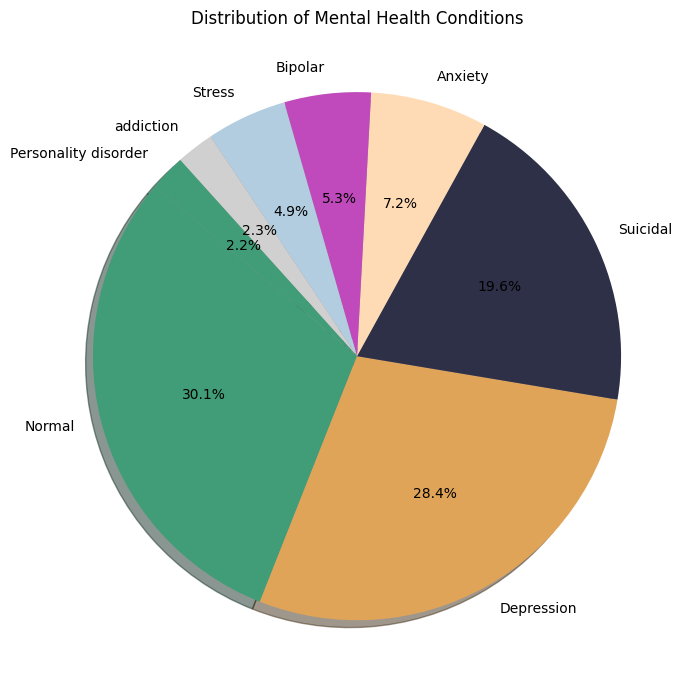

In [10]:
import matplotlib.pyplot as plt
# Count the occurrences of each category
status_counts = full_data['status'].value_counts()

# Define colors for each category (7 colors)
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%',
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Display the chart
plt.tight_layout()
plt.show()

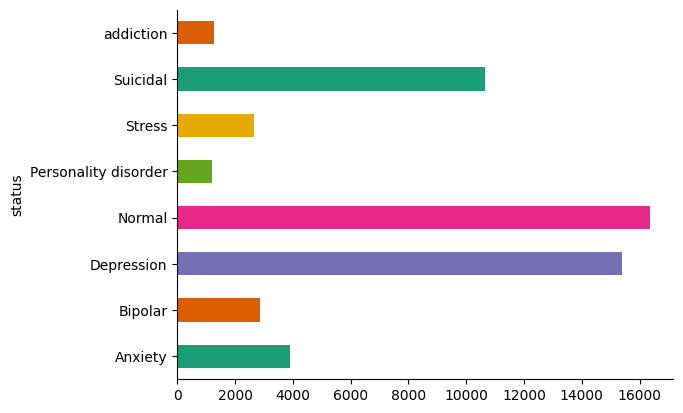

In [11]:
!pip install seaborn
import seaborn as sns
import matplotlib.pyplot as plt
full_data.groupby('status').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [12]:
!pip install -U imbalanced-learn
from imblearn.over_sampling import SMOTE

from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TfidfVectorizer object
vectorizer = TfidfVectorizer()

# Fit the vectorizer to your preprocessed text data and transform it
X_vec = vectorizer.fit_transform(X)  # X is your 'processed_text' column

# Now apply SMOTE to the numerical representation
smote = SMOTE(random_state=42) # SMOTE is now defined and imported from imblearn.over_sampling
X_resampled, y_resampled = smote.fit_resample(X_vec, y)



In [13]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [14]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest Classifier (or any model of your choice)
model = RandomForestClassifier(random_state=42)
model.fit(X_resampled, y_resampled)


RandomForestClassifier(random_state=42)

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

# Make predictions
y_pred = model.predict(X_resampled)

# Evaluate the model
print(confusion_matrix(y_resampled, y_pred))
print(classification_report(y_resampled, y_pred))


[[16143     0     3     1   204     0     0     0]
 [    0 15793     0     1   557     0     0     0]
 [   11     1 16317     8     1     0    13     0]
 [    5     0     2 16175   166     2     1     0]
 [    0     0     0     0 16351     0     0     0]
 [    0     0     6     0   481 15864     0     0]
 [    0     0     8     3     2     0 16338     0]
 [    0     1     0     0     0     0     0 16350]]
                      precision    recall  f1-score   support

             Anxiety       1.00      0.99      0.99     16351
             Bipolar       1.00      0.97      0.98     16351
          Depression       1.00      1.00      1.00     16351
              Normal       1.00      0.99      0.99     16351
Personality disorder       0.92      1.00      0.96     16351
              Stress       1.00      0.97      0.98     16351
            Suicidal       1.00      1.00      1.00     16351
           addiction       1.00      1.00      1.00     16351

            accuracy           

In [16]:
import pickle

# Save the trained model
with open('mental_health_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

# Save the vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)



In [17]:
# Load the trained model
with open('mental_health_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

# Load the vectorizer
with open('tfidf_vectorizer.pkl', 'rb') as vectorizer_file:
    loaded_vectorizer = pickle.load(vectorizer_file)


In [18]:
def get_user_input():
    """Prompt user for input and preprocess the text."""
    user_input = input("Please enter the text for prediction: ")
    processed_input = preprocess_text(user_input)
    return processed_input


In [19]:
def vectorize_input(input_text):
    """Vectorize the preprocessed user input."""
    return loaded_vectorizer.transform([input_text])


In [21]:
# Get user input
user_text = get_user_input()

# Vectorize the user input
user_input_vectorized = vectorize_input(user_text)

# Make a prediction using the loaded model
prediction = loaded_model.predict(user_input_vectorized)

# Display the predicted mental health condition
print(f"The predicted mental health condition is: {prediction[0]}")


Please enter the text for prediction: what a great day!
The predicted mental health condition is: Normal
